In [1]:
import sys 
import os
sys.path.append(os.path.join(os.path.split(sys.path[0])[0], 'src'))
sys.path.append('../src') 
import numpy as np
a = np.ones((1,1))
a@a
import matplotlib.pyplot as plt
import KPCA
from KPCA import compute_kernel_matrix
from utils import get_data, calc_energy



from plotly.io import show
import glob

In [2]:
def get_matrix(filename, ndata = 3000):
    #reads the file
    filename_no_ext = ".".join(filename.split('.')[:-1])
    f_split = filename_no_ext.split('_')
    Re = float(f_split[2].replace('Re',''))
    Wi = float(f_split[3].replace('Wi',''))
    beta = float(f_split[4].replace('beta',''))
    eps = float(f_split[5].replace('a',''))
    fields = np.load(f'{dspath}/{filename}', allow_pickle=True)["fields"].item()
    param =  np.repeat((Re,Wi,beta), ntimes).reshape((3,-1)).T
    #Extract the fields
    u = fields["vel-u"]
    v = fields["vel-v"]
    Bxx = fields["Bxx"]
    Bxy = fields["Bxy"]
    Byy = fields["Byy"]
    q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)


    # reshape for the expected code format
    TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2]))
    TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2]))
    T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
    T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
    T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
    T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0
    theta_sqrt = np.sqrt((1-param[:,2])/(param[:,0] * param[:,1])).reshape((-1,1))
    X =  T[:,1:ndata+1]
    return X.T, theta_sqrt, (Re, Wi, beta, eps)

In [3]:
# dspath = '/home/fabio/npz_data/KPCA_4roll' # Four roll
dspath = '../../npz_data/dataset_giesekus' # cavity

files = glob.glob('*.npz', root_dir=dspath)
X = []
P = []
ntimes = 100
n_data = ntimes * len(files)



Nx = Ny = 80
npoints = (Nx * Ny)*5
nfiles = len(files)

datset_matrix_low = np.empty((0,npoints))
datset_theta_low = np.empty((0,1))
datset_param_low = np.empty((0,4))

datset_matrix_high = np.empty((0,npoints))
datset_theta_high = np.empty((0,1))
datset_param_high = np.empty((0,4))

for i in range(len(files)):
    X1, t, eps = get_matrix(files[i], ntimes)
    if t[0] > 1:
        datset_matrix_high = np.concat((datset_matrix_high, X1),0)
        datset_theta_high = np.concat((datset_theta_high, t),0)
        datset_param_high = np.concat((datset_param_high, np.tile(eps,ntimes).reshape(-1,4)),0)
    else:
        datset_matrix_low = np.concat((datset_matrix_low, X1),0)
        datset_theta_low = np.concat((datset_theta_low, t),0)
        datset_param_low = np.concat((datset_param_low, np.tile(eps,ntimes).reshape(-1,4)),0)

In [4]:
## Select Dataset

X = datset_matrix_high
theta_matrix = datset_theta_high
params = datset_param_high


# dataset_matrix = datset_matrix_low
# theta = datset_theta_low
# params = datset_param_low

In [5]:
modes = [i for i in range(2,11)]
best_sigma_mult = []
studies_mult = []

# 1 - Read Data
dx = dy = 1/80
ntimes = 100
n_data = params.shape[0]
n_sim = n_data // ntimes
Nx = Ny = 80
npoints = (Nx * Ny)*5
theta_mult = theta_matrix @ theta_matrix.T
theta = np.diag(theta_mult)[:,None]
alpha = params[:,-1:]
alpha_mult = np.sqrt(alpha @ alpha.T)

print(theta.shape, alpha_mult.shape, alpha.shape)

(500, 1) (500, 500) (500, 1)


In [6]:
kernels_type = ['linear', 'giesekus', 'poly', 'cosine']
kernels = [KPCA.KernelPCA() for i in range(len(kernels_type))]

for i, ker in enumerate(kernels_type):
    if ker == 'giesekus':
        kernels[i].fit(X, 10, ker, theta_mult,eps = alpha_mult, dx = dx, dy = dy)
    elif ker == 'poly':
        kernels[i].fit(X, 10, ker, theta_mult,eps = 2, dx = dx, dy = dy)
    else:
        kernels[i].fit(X, 10, ker, theta_mult,eps = None, dx = dx, dy = dy)


ValueError: operands could not be broadcast together with shapes (500,10) (500,500) 

In [63]:
Re_total = params[:,0]
Wi_total = params[:,1]
beta_total = params[:,2]
_, _, energy_X = calc_energy(X.T,Wi_total,beta_total, Re_total, dx, dy)

mse = np.linalg.norm(X, axis=1)
mse.shape, energy_X.shape

((500,), (500,))

In [64]:
sum_energy = np.zeros(n_sim)
sum_mse = np.zeros(n_sim)
for i in range(n_sim):
    sum_energy[i] = np.sum(np.abs(energy_X[i*ntimes:(i+1)*ntimes]))
    sum_mse[i] = np.linalg.norm(energy_X[i*ntimes:(i+1)*ntimes])

results = np.zeros((len(kernels), len(modes)))
results_mse = np.zeros((len(kernels), len(modes)))
for i,m in enumerate(modes):
    print(f'{m} Modes')
    for j,ker in enumerate(kernels):
        ker.train_R(n_components=m)

        if ker.kernel == 'giesekus':
            phi = ker.transform(X, theta, eps=alpha_mult, dx=dx, dy = dy)
        elif ker.kernel == 'poly':
            phi = ker.transform(X, theta, eps=2, dx=dx, dy = dy)
        else:
            phi = ker.transform(X, theta, eps=None, dx=dx, dy = dy)
        X_rec = ker.invert_transform(phi, theta.T)

        # 4- Calc error
        _, _, energy_rec = calc_energy(X_rec,Wi_total,beta_total, Re_total, dx, dy)

        # 4- Calc error
        err = 0
        # results_mse[j,i] = np.linalg.norm(X - X_rec.T) / norm_mse
        for sim in range(n_sim):
            err += np.sum(np.abs(energy_X[sim*ntimes:(sim+1)*ntimes] - energy_rec[sim*ntimes:(sim+1)*ntimes])) / sum_energy[sim]
        

        results[j,i] = err/n_sim

2 Modes
3 Modes
4 Modes
5 Modes
6 Modes
7 Modes
8 Modes
9 Modes
10 Modes


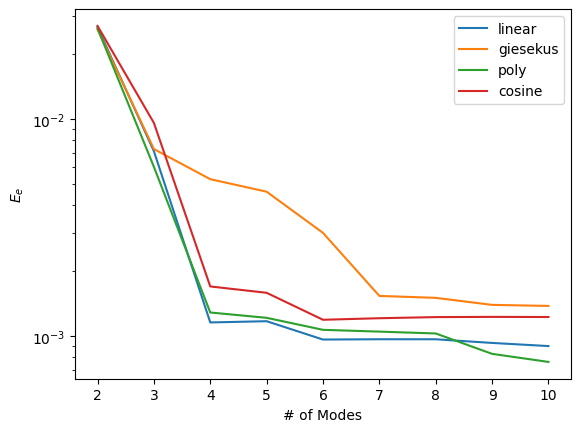

In [65]:
for i, k in enumerate(results):
    plt.plot(modes,k, label = kernels_type[i])
# plt.plot(modes,results_rbf, label = 'RBF')
plt.xlabel('# of Modes')
plt.ylabel('$E_e$')
plt.legend()
plt.yscale('log')

In [66]:
energies = []
m = 3
for j,ker in enumerate(kernels):
        ker.train_R(n_components=m)

        if ker.kernel == 'giesekus':
            phi = ker.transform(X, theta, eps=alpha_mult, dx=dx, dy = dy)
        elif ker.kernel == 'poly':
            phi = ker.transform(X, theta, eps=2, dx=dx, dy = dy)
        else:
            phi = ker.transform(X, theta, eps=None, dx=dx, dy = dy)
        X_rec = ker.invert_transform(phi, theta.T)

        # 4- Calc error
        _, _, energy_rec = calc_energy(X_rec,Wi_total,beta_total, Re_total, dx, dy)
        energies.append(energy_rec)

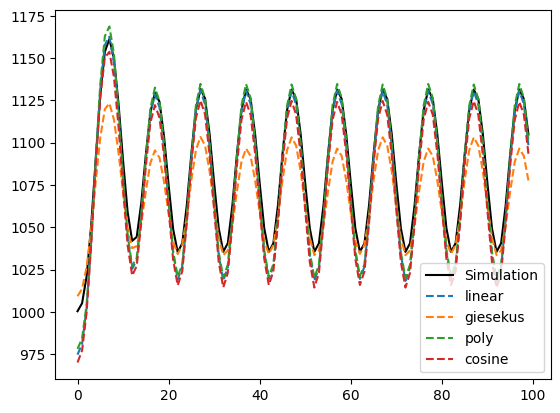

In [67]:
sim = 0
plt.plot(energy_X[sim*ntimes:(sim+1)*ntimes],'k', label = 'Simulation')
for k, e in zip(kernels_type, energies):
    plt.plot(e[sim*ntimes:(sim+1)*ntimes],'--', label = k)
plt.legend()

Text(0.5, 1.0, 'Forbenius Norm')

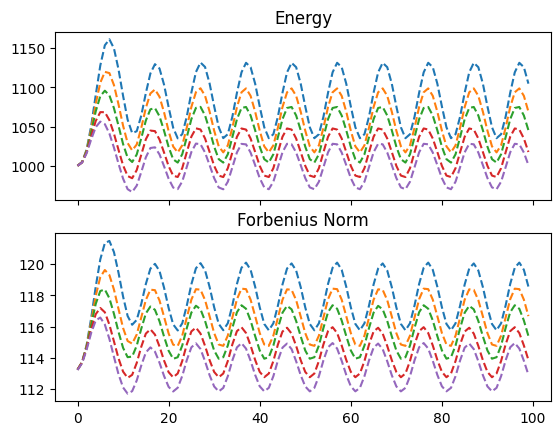

In [68]:
f, ax = plt.subplots(2,1, sharex=True)
for i in range(5):
    ax[0].plot(energy_X[i*100:(i+1)*100],'--', label = 'Simulation')
    ax[1].plot(mse[i*100:(i+1)*100],'--', label = 'Simulation')

ax[0].set_title('Energy')
# ax[0].set_yscale('log')
ax[1].set_title('Forbenius Norm')